<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/dphi/ds98/notebooks/00_eda_and_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#Utils
import gc
import os
import time
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

#Data analysis
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Reproducibility
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [2]:
#Modeling
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
#Data
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/dphi/ds98/data'
train = pd.read_csv(f'{DATA_URL}/raw/train_dataset.csv')
test = pd.read_csv(f'{DATA_URL}/raw/test_dataset.csv')

# Data Overview

In [4]:
train.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
0,0,0,0,0,-25.9668,-8.2766,30.7879,0.5220,-0.4905,-0.0315,5
1,1,0,0,1,827.9293,65.2351,-14.9172,-0.1813,-0.0087,0.1900,3
2,0,0,0,0,-26.2914,92.2471,-68.8537,-0.6161,0.2767,0.3394,5
3,1,0,1,1,849.6428,-273.2656,25.5281,0.0275,-0.3389,0.3115,2
4,0,0,0,0,-48.6769,95.3330,-49.7782,-0.5520,0.0487,0.5033,5


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3930 entries, 0 to 3929
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   G           3930 non-null   int64  
 1   C           3930 non-null   int64  
 2   B           3930 non-null   int64  
 3   A           3930 non-null   int64  
 4   Ia          3930 non-null   float64
 5   Ib          3930 non-null   float64
 6   Ic          3930 non-null   float64
 7   Va          3930 non-null   float64
 8   Vb          3930 non-null   float64
 9   Vc          3930 non-null   float64
 10  Fault_Type  3930 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 337.9 KB


In [6]:
train.shape, test.shape

((3930, 11), (3931, 10))

In [7]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

No missing values.

### Target

In [8]:
TARGET = 'Fault_Type'

In [9]:
train[TARGET].value_counts(normalize=True)

5    0.3008
2    0.1443
1    0.1440
3    0.1438
0    0.1394
4    0.1277
Name: Fault_Type, dtype: float64

In [10]:
features = list(test.columns)
features

['G', 'C', 'B', 'A', 'Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

# Adversarial Validation

In [11]:
train['set'] = 0
test['set'] = 1
composite = pd.concat([train, test], axis=0, ignore_index=True).drop(TARGET, axis=1)

In [12]:
composite.set.value_counts()

1    3931
0    3930
Name: set, dtype: int64

In [13]:
%%time
X, y = composite[features], composite['set']
scores = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

    model = ExtraTreesClassifier(
        n_estimators=150,  
        max_depth=7,
        n_jobs=-1, 
        random_state=SEED
    )

    model.fit(X_train, y_train)
    val_probs = model.predict_proba(X_val)[:, 1]

    score = roc_auc_score(y_val, val_probs)
    scores.append(score)
    print(f'Fold #{fold}: {score:.5f}')
    _ = gc.collect()

print(f'Avg AUC = {np.mean(scores):.5f} +/- {np.std(scores):.5f}\n')

Fold #0: 0.50142
Fold #1: 0.50435
Fold #2: 0.51565
Fold #3: 0.50370
Fold #4: 0.51267
Avg AUC = 0.50756 +/- 0.00556

CPU times: user 3.81 s, sys: 215 ms, total: 4.02 s
Wall time: 3.02 s


Train and test sets cannot be differentiated based on features.  
Thus, we can trust CV score for performance on test set.

In [14]:
del composite
gc.collect()

0

# Plotting utils

In [15]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(20, 5))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    ax[0].grid(True, which='major')
    ax[0].minorticks_on()
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    ax[1].grid(True, which='major')
    ax[1].minorticks_on()
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax[2], palette='bright', cut=0)
    ax[2].set_title('Train data splits by target category')
    ax[2].grid(True, which='major')
    ax[2].minorticks_on()
    # fig.tight_layout()
    plt.show()

In [16]:
def explore_cont(feature):
    #Feature distribution 
    describe_df = pd.DataFrame()
    describe_df.index = train[feature].describe().index
    describe_df['Train'] = train[feature].describe().values
    describe_df['Test'] = test[feature].describe().values
    print('\nFeature distribution:')
    display(describe_df.T)
    plot_cont(feature)
    #Feature distribution grouped by target class
    print(f'\nFeature distribution vs target variable:')
    display(train.groupby(TARGET)[feature].describe())

In [17]:
def explore_cat(feature):
    #Unique values
    print(f'\nNumber of unique values: ' \
          f'Train - {train[feature].nunique()}, Test - {test[feature].nunique()}')
    print(f'Unique values: ')
    print(f'Train - {pd.unique(train[feature])}')
    print(f'Test - {pd.unique(test[feature])}')
    #Value counts
    print(f'\nNormalized value counts:')
    train_value_counts = train[feature].value_counts(normalize=True, dropna=False).to_frame()
    test_value_counts = test[feature].value_counts(normalize=True, dropna=False).to_frame()
    counts_df = train_value_counts.join(test_value_counts, lsuffix='_Train', rsuffix='_Test')
    display(counts_df.T)
    #Target grouped by feature
    print(f'\nTarget value counts grouped by feature:')
    display(train.groupby(feature)[TARGET].value_counts(normalize=True))

# Feature exploration

### G, C, B, A

In [18]:
explore_cat('G')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - [0 1]
Test - [0 1]

Normalized value counts:


,0,1
G_Train,0.5679,0.4321
G_Test,0.5680,0.4320



Target value counts grouped by feature:


G  Fault_Type
0  5             0.5296
   0             0.2455
   4             0.2249
1  2             0.3339
   1             0.3333
   3             0.3327
Name: Fault_Type, dtype: float64

In [19]:
explore_cat('C')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - [0 1]
Test - [1 0]

Normalized value counts:


,0,1
C_Train,0.5888,0.4112
C_Test,0.5887,0.4113



Target value counts grouped by feature:


C  Fault_Type
0  5             0.5108
   2             0.2450
   3             0.2442
1  1             0.3502
   0             0.3391
   4             0.3106
Name: Fault_Type, dtype: float64

In [20]:
explore_cat('B')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - [0 1]
Test - [1 0]

Normalized value counts:


,1,0
B_Train,0.5555,0.4445
B_Test,0.5556,0.4444



Target value counts grouped by feature:


B  Fault_Type
0  5             0.6766
   3             0.3234
1  2             0.2597
   1             0.2593
   0             0.2510
   4             0.2300
Name: Fault_Type, dtype: float64

In [21]:
explore_cat('A')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - [0 1]
Test - [0 1]

Normalized value counts:


,1,0
A_Train,0.5715,0.4285
A_Test,0.5714,0.4286



Target value counts grouped by feature:


A  Fault_Type
0  5             0.7019
   4             0.2981
1  2             0.2524
   1             0.2520
   3             0.2516
   0             0.2440
Name: Fault_Type, dtype: float64

* 0 -> C, B, A
* 1 -> G, C, B, A
* 2 -> G, B, A
* 3 -> G, A
* 4 -> C, B
* 5 -> None

### Ia, Ib, Ic


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,3930.0,11.4637,467.3529,-883.5423,-138.0070,0.8852,225.5907,885.5470
Test,3931.0,15.9781,462.1648,-883.4687,-103.3874,3.0017,233.7624,885.7386


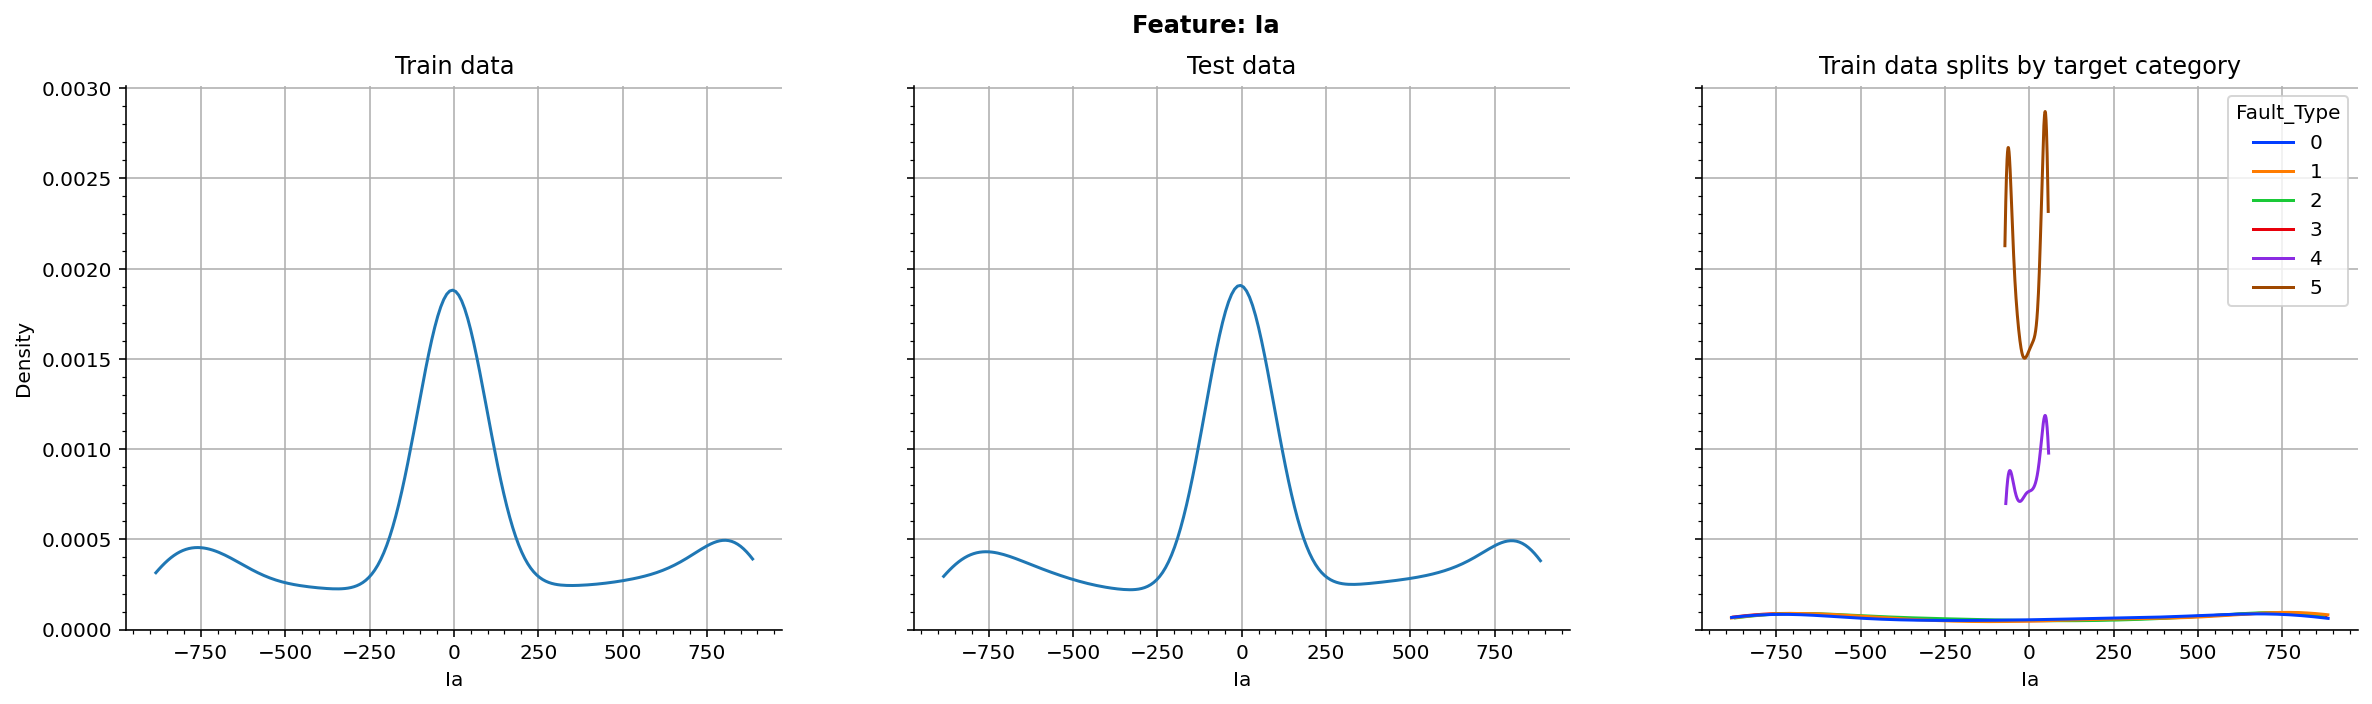


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Fault_Type,,,,,,,,
0,548.0,10.5436,605.8290,-882.8266,-635.1660,90.7661,586.1859,885.5470
1,566.0,42.8822,628.0539,-883.5423,-594.4955,96.3674,695.4988,884.7642
2,567.0,25.2863,611.9963,-871.2344,-576.2295,10.7362,644.6477,872.6120
3,565.0,17.9050,621.7208,-877.8108,-621.1108,47.7644,635.8115,879.3421
4,502.0,-1.1063,43.2247,-70.0357,-42.3630,1.8223,41.0115,56.9472
5,1182.0,-7.5255,45.1603,-72.6599,-52.7471,-6.7727,39.0763,55.7572


In [22]:
explore_cont('Ia')


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,3930.0,-35.4703,436.1726,-900.527,-234.4652,8.3203,93.2732,889.7881
Test,3931.0,-54.2178,442.2002,-900.409,-303.9074,3.4561,88.2969,889.8689


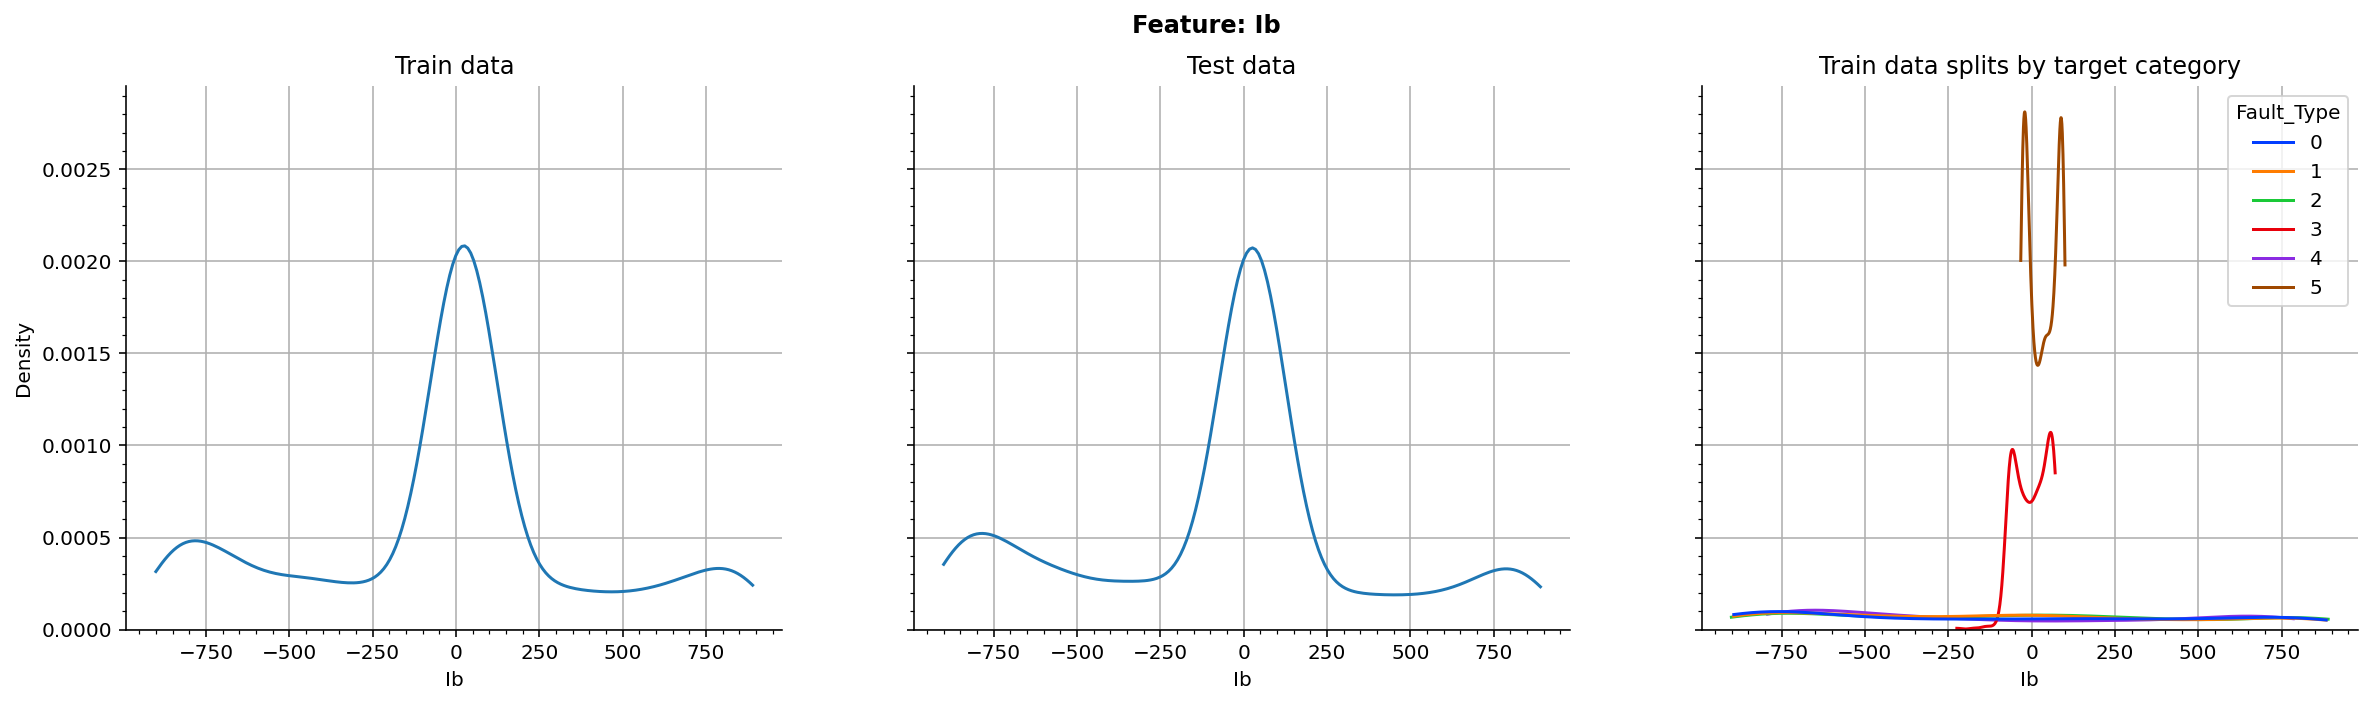


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Fault_Type,,,,,,,,
0,548.0,-94.7519,606.3763,-893.2041,-690.1130,-151.3870,465.6719,884.0264
1,566.0,-88.3541,575.2510,-893.7963,-622.7843,-99.8159,384.3125,883.3431
2,567.0,-56.6480,581.5135,-900.5270,-610.7745,-43.8028,416.1308,889.7881
3,565.0,-0.2684,51.3424,-224.1594,-48.7713,1.7959,48.9509,70.7881
4,502.0,-90.2647,551.5192,-792.1055,-623.6070,-206.5451,465.7067,785.0870
5,1182.0,33.9408,45.4947,-32.4352,-12.6893,35.9461,80.2598,100.2471


In [23]:
explore_cont('Ib')


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,3930.0,28.1572,372.3415,-883.3578,-62.8367,-3.7095,48.6711,901.1012
Test,3931.0,40.6260,369.8118,-883.2097,-58.9158,-5.0625,49.6648,901.2743


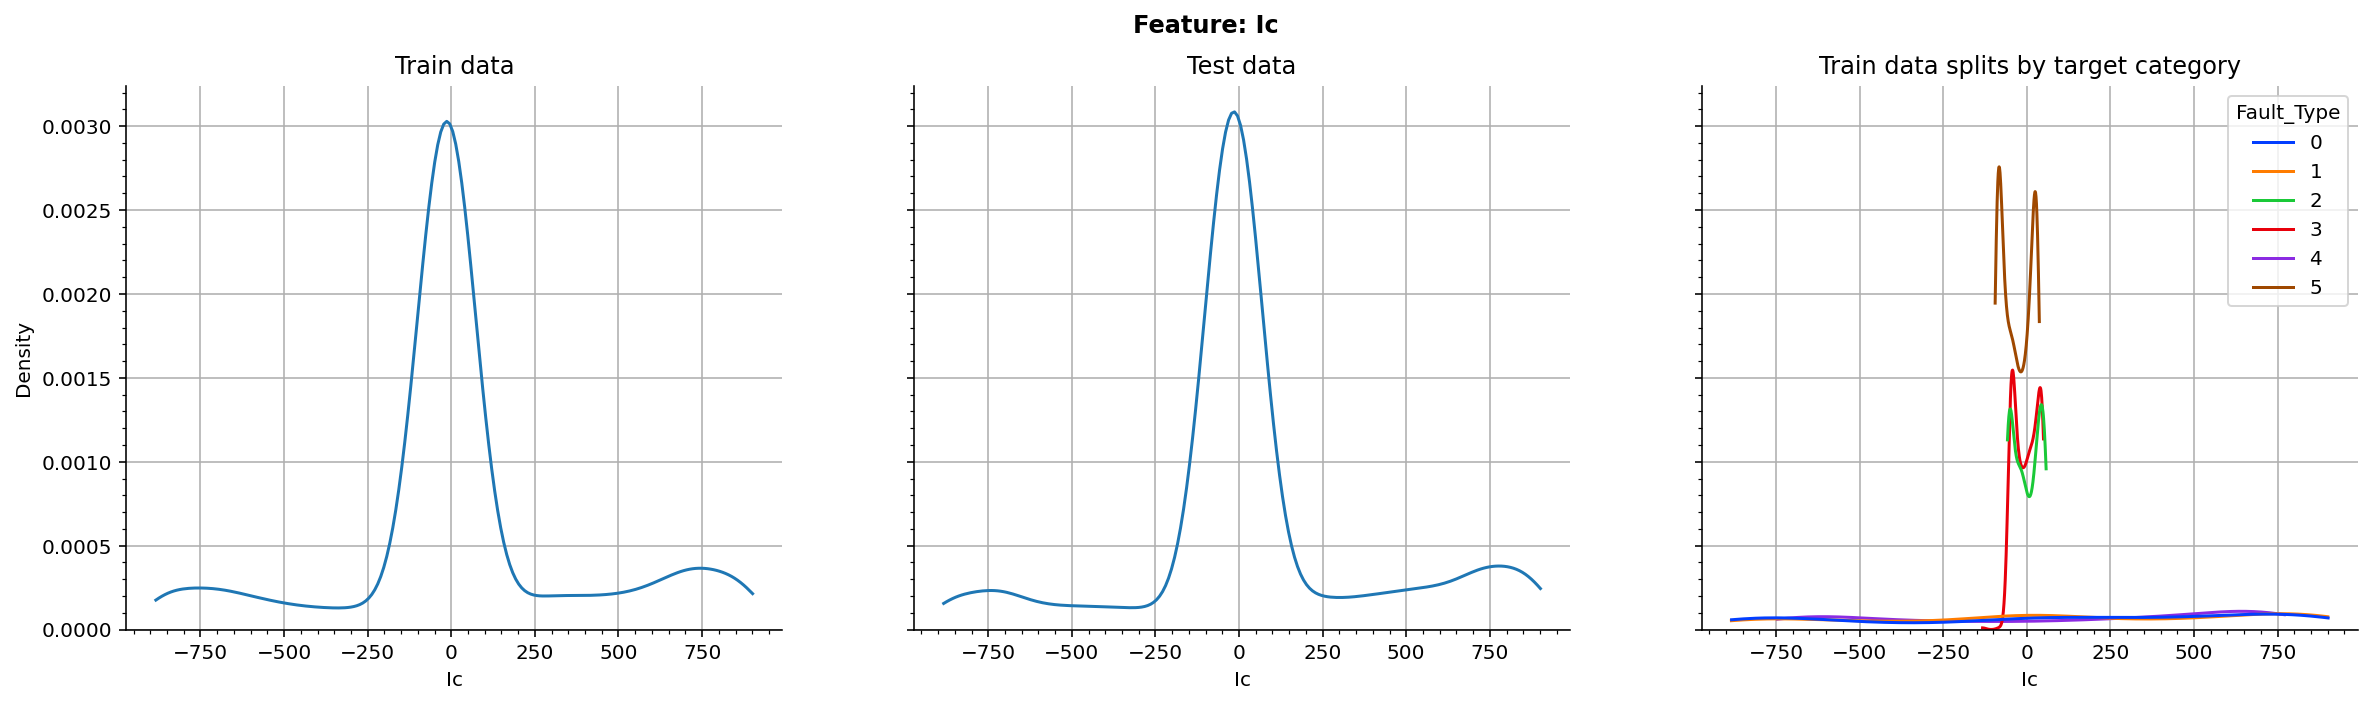


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Fault_Type,,,,,,,,
0,548.0,86.2973,597.0538,-882.7489,-501.0638,160.3617,645.8805,901.1012
1,566.0,93.0857,583.6185,-883.3578,-407.6390,61.7992,640.0943,899.9067
2,567.0,-1.1750,39.9962,-57.7826,-40.7740,-2.6026,37.5068,57.7826
3,565.0,-1.3939,35.3687,-132.2828,-37.1512,0.5374,31.0270,49.9139
4,502.0,93.8951,532.3937,-746.0621,-437.9706,196.5645,624.1063,770.1681
5,1182.0,-29.6118,44.3611,-94.6236,-73.6812,-32.2341,14.2236,37.4990


In [24]:
explore_cont('Ic')

### Va, Vb, Vc


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,3930.0,-0.0040,0.2905,-0.6207,-0.1215,-0.0021,0.1226,0.5953
Test,3931.0,-0.0114,0.2878,-0.6207,-0.1432,-0.0086,0.0970,0.5953


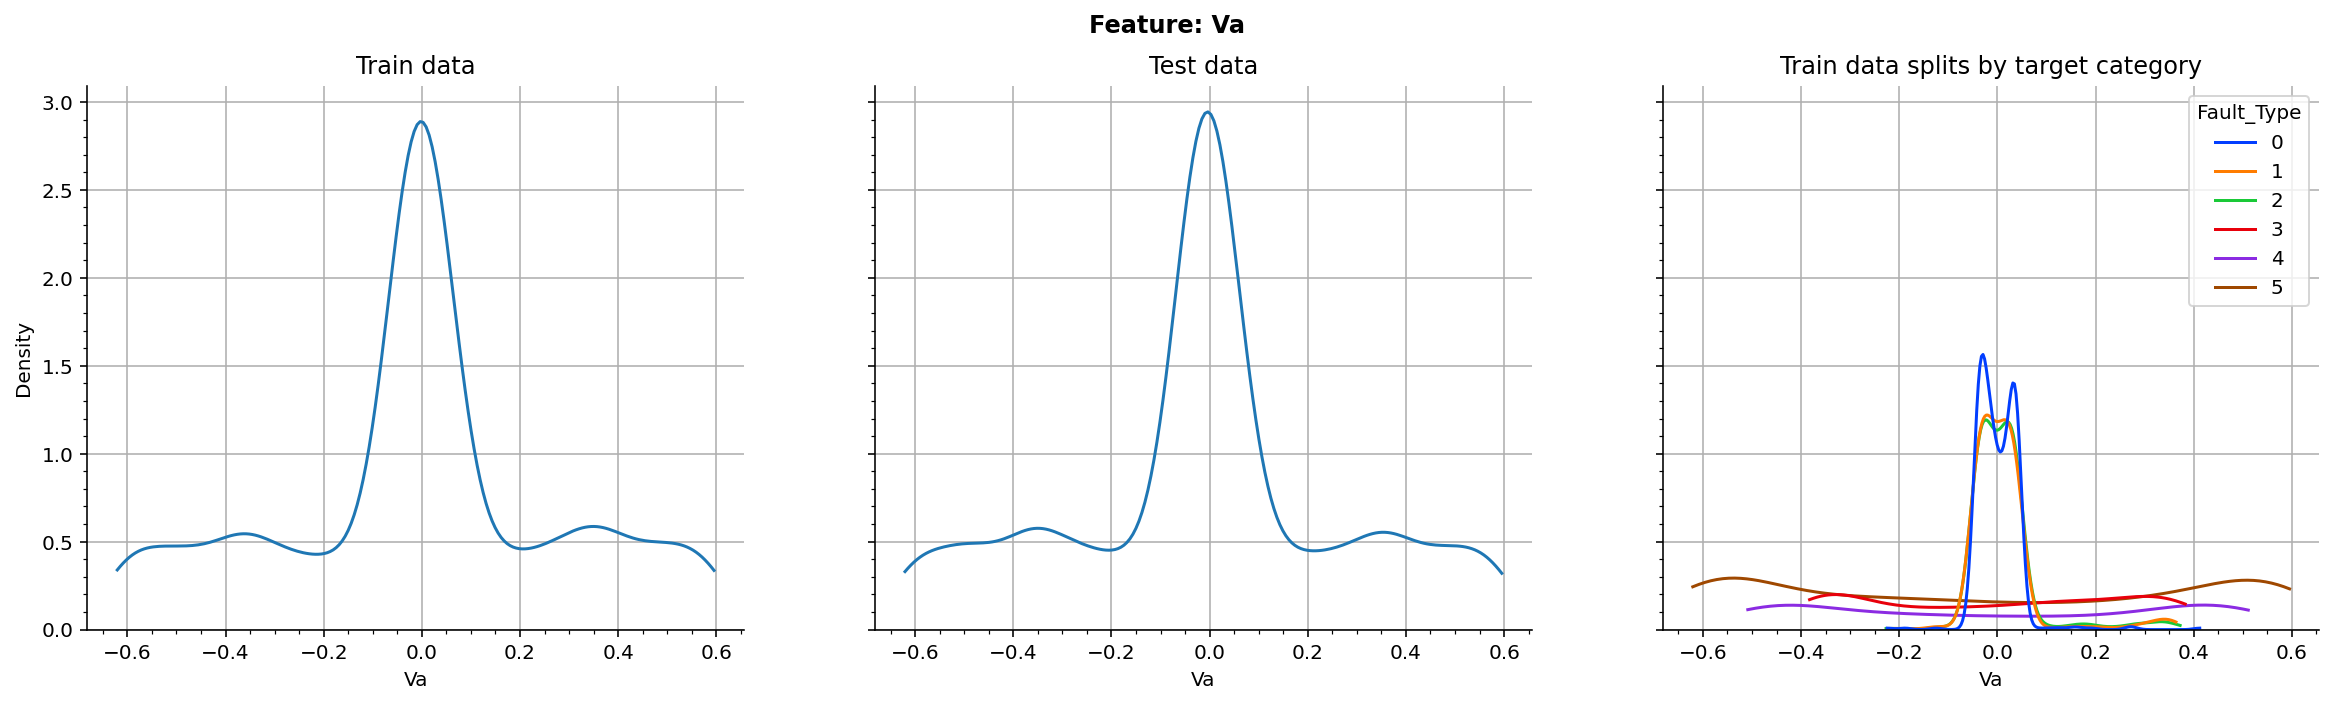


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Fault_Type,,,,,,,,
0,548.0,0.0009,0.0433,-0.2245,-0.0306,-0.0042,0.0309,0.4123
1,566.0,0.0115,0.0740,-0.2234,-0.0321,0.0009,0.0309,0.3639
2,567.0,0.0124,0.0720,-0.2269,-0.0318,0.0022,0.0320,0.3724
3,565.0,-0.0031,0.2631,-0.3827,-0.2766,0.0205,0.2412,0.3827
4,502.0,-0.0037,0.3629,-0.5086,-0.3773,-0.0114,0.3737,0.5112
5,1182.0,-0.0220,0.4305,-0.6207,-0.4541,-0.0473,0.4074,0.5953


In [25]:
explore_cont('Va')


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,3930.0,-0.0018,0.3124,-0.6080,-0.1672,-0.0010,0.1494,0.6279
Test,3931.0,0.0041,0.3145,-0.6078,-0.1499,0.0037,0.1606,0.6278


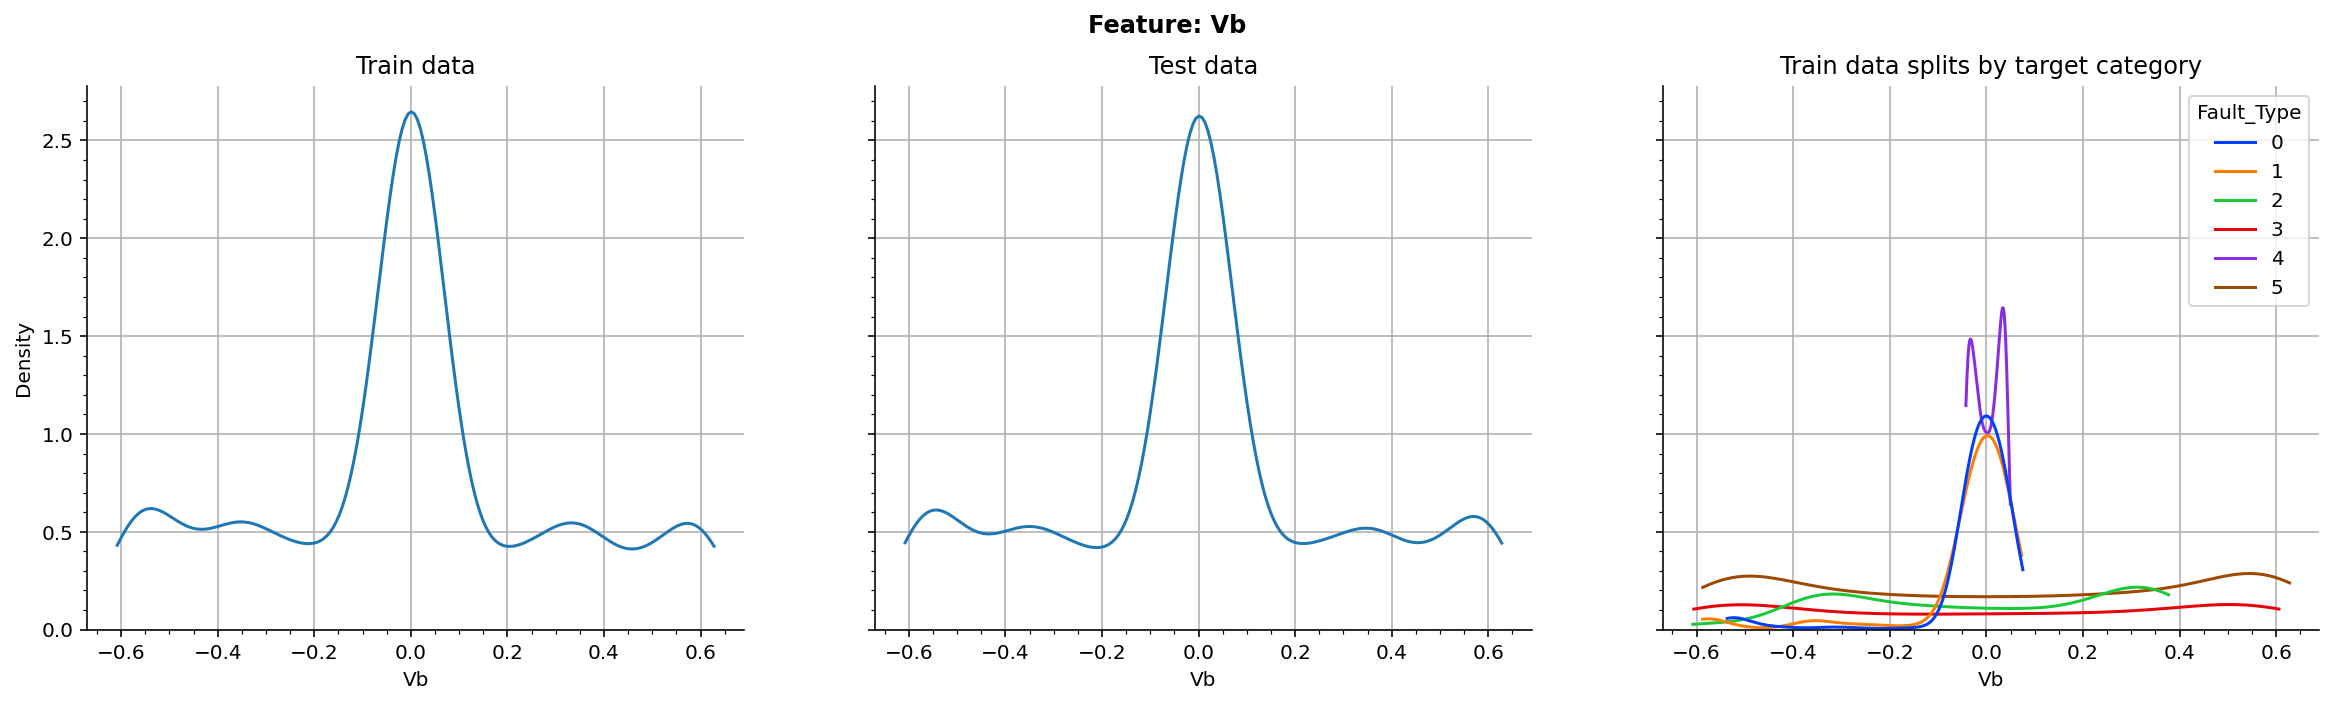


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Fault_Type,,,,,,,,
0,548.0,-0.0290,0.1178,-0.5368,-0.0319,-0.0055,0.0281,0.0756
1,566.0,-0.0429,0.1380,-0.5876,-0.0369,-0.0059,0.0272,0.0732
2,567.0,-0.0126,0.2929,-0.6080,-0.2950,-0.0077,0.2863,0.3772
3,565.0,0.0044,0.4266,-0.6059,-0.4346,0.0087,0.4290,0.6059
4,502.0,0.0013,0.0292,-0.0424,-0.0262,0.0020,0.0298,0.0497
5,1182.0,0.0315,0.4223,-0.5874,-0.3871,0.0379,0.4484,0.6279


In [26]:
explore_cont('Vb')


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,3930.0,0.0057,0.3096,-0.6127,-0.2232,0.0081,0.2435,0.6002
Test,3931.0,0.0073,0.3063,-0.6125,-0.2068,0.0103,0.2356,0.6002


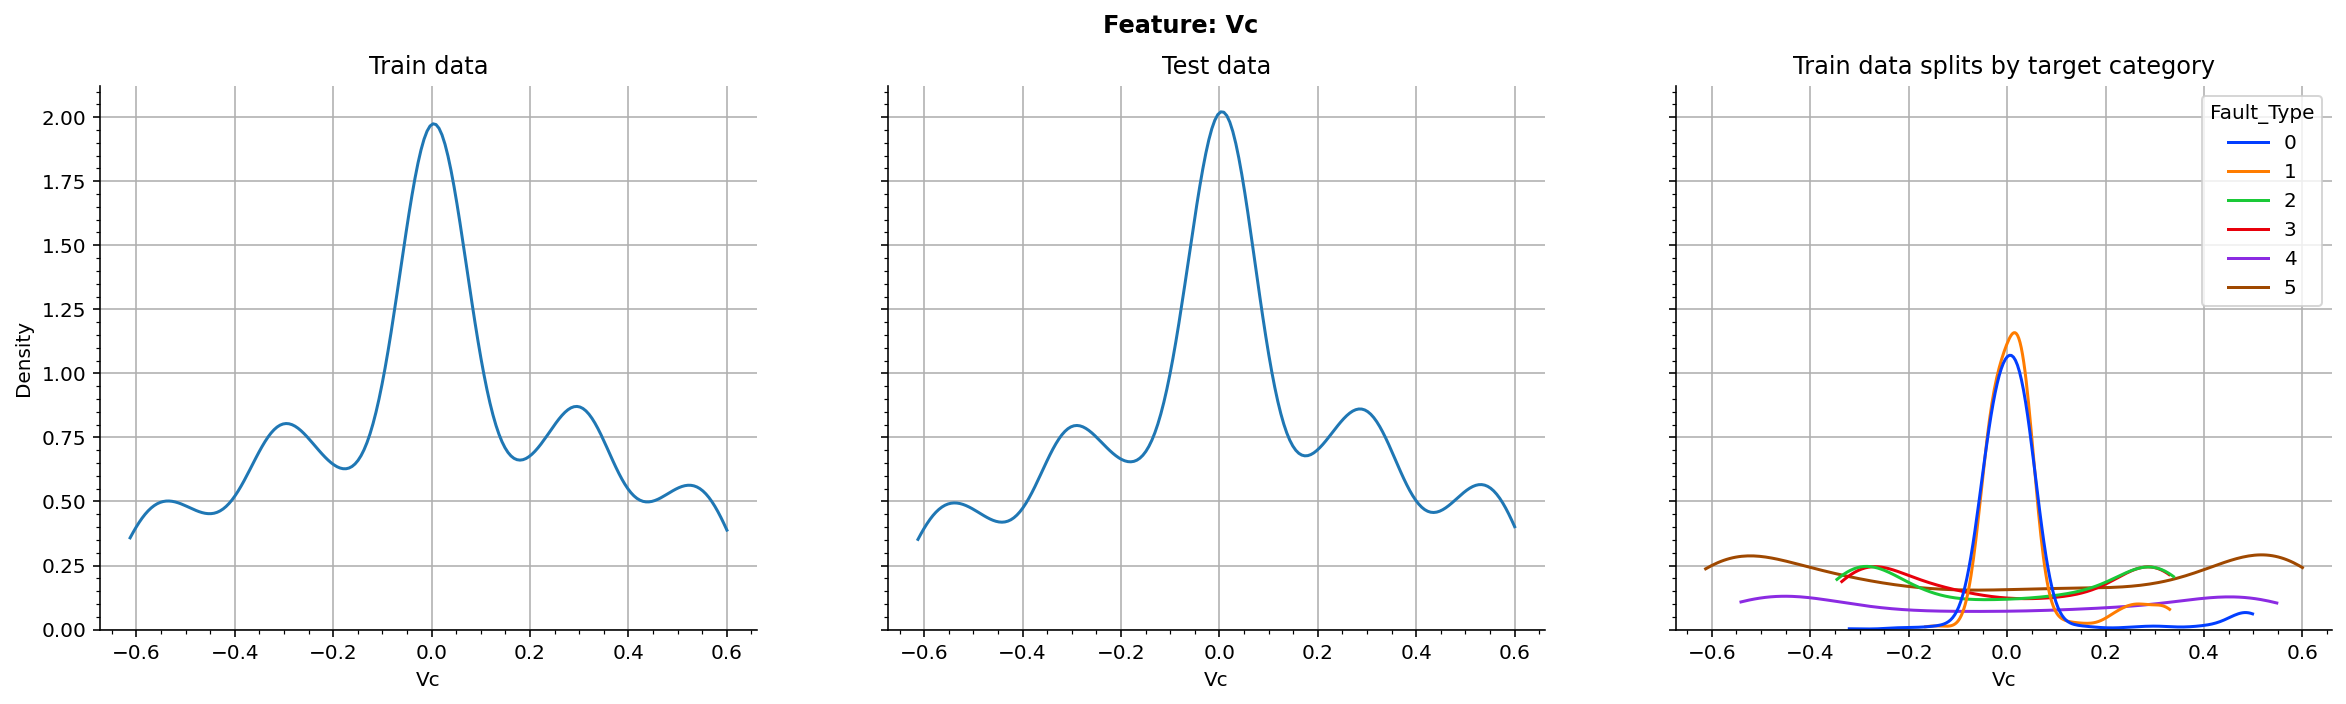


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
Fault_Type,,,,,,,,
0,548.0,0.0282,0.1129,-0.3208,-0.0262,0.0087,0.0384,0.4988
1,566.0,0.0314,0.0887,-0.1655,-0.0222,0.0137,0.0391,0.3302
2,567.0,0.0002,0.2491,-0.3459,-0.2588,-0.0026,0.2622,0.3382
3,565.0,-0.0012,0.2401,-0.3360,-0.2406,-0.0197,0.2530,0.3291
4,502.0,0.0025,0.3900,-0.5409,-0.3934,0.0125,0.4003,0.5481
5,1182.0,-0.0096,0.4319,-0.6127,-0.4362,-0.0144,0.4377,0.6002


In [27]:
explore_cont('Vc')

# Feature selection

In [28]:
cat_features = ['G', 'C', 'B', 'A']
num_features = [f for f in features if f not in cat_features]
num_features

['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']

### Correlation (Kendall-Tau)

In [29]:
def plot_corr_matrix(corr_df, size=12):
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(corr_df,
                mask=np.triu(np.ones_like(corr_df)),
                vmin=-1, vmax=1, center=0, 
                annot=True, fmt='.2f',
                linewidths=0.1)
    plt.show()

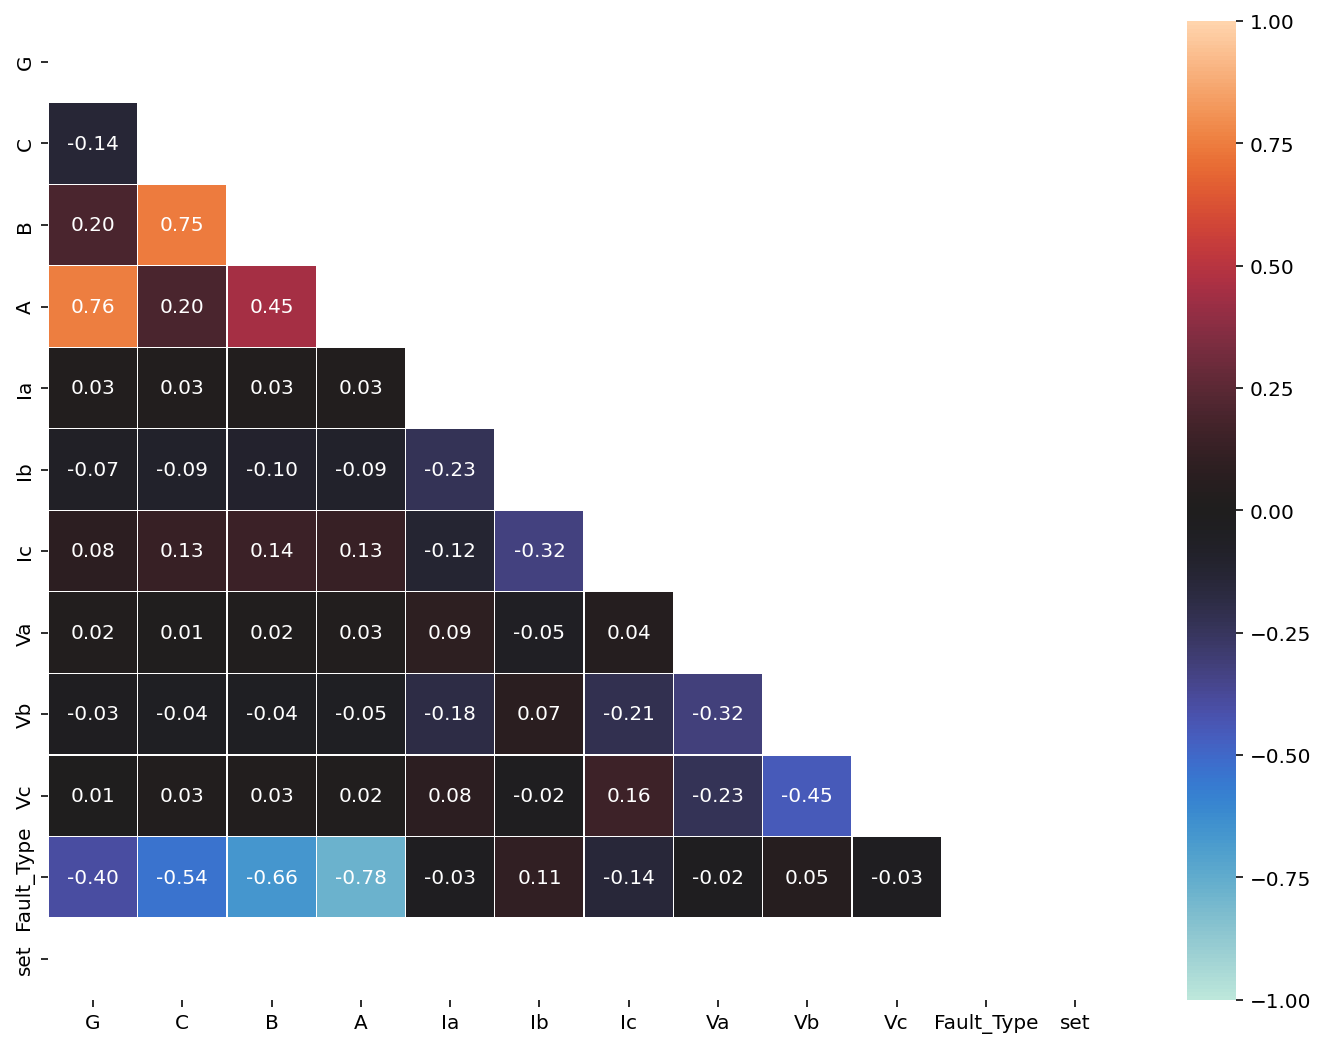

In [30]:
corr_df = train.corr(method='kendall')
plot_corr_matrix(corr_df)

### ANOVA f-test

In [31]:
anova_test = f_classif(train[num_features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=num_features
)

,f-statistic,p-value,accepted?
Ia,1.0957,3.6049e-01,False
Ib,12.4418,5.2964e-12,True
Ic,16.6762,2.4680e-16,True
Va,1.6181,1.5159e-01,False
Vb,5.7073,2.9801e-05,True
Vc,2.0398,7.0038e-02,False


### Chi-squared test of independence

In [32]:
chi2_test = chi2(train[cat_features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': chi2_test[0], 
        'p-value': chi2_test[1],
        'accepted?': chi2_test[1] < 0.05
    },
    index=cat_features
)

,f-statistic,p-value,accepted?
G,2232.0,0.0,True
C,2314.0,0.0,True
B,1747.0,0.0,True
A,1684.0,0.0,True


### Variance Inflation Factor (VIF)

In [33]:
%%capture
!pip install --upgrade statsmodels==0.13.2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [34]:
def remove_vif_features(X: pd.DataFrame, threshold: float = 5.0) -> list:
    """Remove feature with highest Variance Inflation Factor
    at every iteration until all remaining features are below
    a certain threshold.
    """
    i = 0
    while True:
        vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        max_vif = np.max(vif)

        if max_vif <= threshold:
            break

        i += 1
        col_to_remove = X.columns[np.argmax(vif)]
        print(f"Iteration {i}: {col_to_remove:20} ({max_vif:.4f})")
        X.drop(col_to_remove, axis=1, inplace=True)

    if i == 0:
        print(f"No columns removed")
    else:
        print(pd.DataFrame({"Feature": X.columns, "VIF": vif}))

    return list(X.columns)

In [35]:
_ = remove_vif_features(train[features], 5) #rule-of-thumb threshold

Iteration 1: Va                   (inf)
Iteration 2: A                    (6.9645)
Iteration 3: B                    (6.2175)
  Feature     VIF
0       G  1.1342
1       C  1.1617
2      Ia  2.2611
3      Ib  2.5552
4      Ic  2.5244
5      Vb  1.5533
6      Vc  1.5649


### Mutual Information

In [36]:
cat_mask = [(f in cat_features) for f in features]

mi_scores = mutual_info_classif(train[features], train[TARGET], 
                                discrete_features=cat_mask, random_state=SEED)

pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features
).T

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
mi_score,0.6839,0.6773,0.687,0.6829,0.5501,0.6189,0.6915,0.5824,0.5606,0.6865


### ExtraTrees feature importances

In [37]:
et = ExtraTreesClassifier(n_estimators=150, max_depth=7, random_state=SEED)
et.fit(train[features], train[TARGET])

ExtraTreesClassifier(max_depth=7, n_estimators=150, random_state=2311)

In [38]:
pd.DataFrame(
    data={'importance': et.feature_importances_},
    index=features
).T

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
importance,0.2154,0.206,0.2297,0.2304,0.0194,0.0204,0.0276,0.0161,0.0151,0.0198


### Reduced features

In [39]:
reduced_features = [f for f in features if f not in ('Ia', 'Va')]

In [40]:
minimal_features = ['G', 'C', 'B', 'A']

# Baseline

In [41]:
def cross_val_predict(features):
    scores = []
    test_preds = {}
    
    X, y = train[features], train[TARGET]
    X_test = test[features]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

        model = ExtraTreesClassifier(
            n_estimators=150,  
            max_depth=7,
            n_jobs=-1, 
            random_state=SEED
        )

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        test_preds[f'fold{fold}'] = model.predict(X_test)

        score = accuracy_score(y_val, val_preds)
        scores.append(score)
        print(f'Fold #{fold}: {score:.5f}')
        _ = gc.collect()

    print(f'Avg Accuracy = {np.mean(scores):.5f} +/- {np.std(scores):.5f}\n')

    test_preds = pd.DataFrame.from_dict(test_preds)
    test_preds['mode'] = test_preds.mode(axis=1)[0].astype('int')

    return test_preds

In [42]:
%%time
test_preds_all = cross_val_predict(features)

Fold #0: 1.00000
Fold #1: 1.00000
Fold #2: 1.00000
Fold #3: 1.00000
Fold #4: 1.00000
Avg Accuracy = 1.00000 +/- 0.00000

CPU times: user 4.4 s, sys: 339 ms, total: 4.73 s
Wall time: 4.19 s


In [43]:
%%time
test_preds_red = cross_val_predict(reduced_features)

Fold #0: 1.00000
Fold #1: 1.00000
Fold #2: 1.00000
Fold #3: 1.00000
Fold #4: 1.00000
Avg Accuracy = 1.00000 +/- 0.00000

CPU times: user 4.3 s, sys: 359 ms, total: 4.65 s
Wall time: 3.99 s


In [44]:
%%time
test_preds_min = cross_val_predict(minimal_features)

Fold #0: 1.00000
Fold #1: 1.00000
Fold #2: 1.00000
Fold #3: 1.00000
Fold #4: 1.00000
Avg Accuracy = 1.00000 +/- 0.00000

CPU times: user 4.01 s, sys: 300 ms, total: 4.31 s
Wall time: 3.79 s


In [45]:
%%time
_ = cross_val_predict(['Ia', 'Ib','Ic', 'Va', 'Vb', 'Vc'])

Fold #0: 0.82188
Fold #1: 0.81170
Fold #2: 0.81170
Fold #3: 0.82570
Fold #4: 0.80916
Avg Accuracy = 0.81603 +/- 0.00652

CPU times: user 5.28 s, sys: 191 ms, total: 5.48 s
Wall time: 6.48 s


# Submission files

In [46]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [47]:
NOTEBOOK = '00'
SUBMISSION_PATH = f'/content/drive/MyDrive/data_science_competitions/dphi/ds98/submissions/nb_{NOTEBOOK}'
if not os.path.isdir(SUBMISSION_PATH):
    os.makedirs(SUBMISSION_PATH)

In [48]:
def create_submission_files(test_preds, feature_set, path=SUBMISSION_PATH):
    for col in test_preds.columns:
        sub = pd.DataFrame()
        sub[TARGET] = test_preds[col]
        sub.to_csv(f'{path}/{feature_set}_{col}.csv', index=False)

In [49]:
create_submission_files(test_preds_all, 'all')

In [50]:
create_submission_files(test_preds_red, 'red')

In [51]:
create_submission_files(test_preds_min, 'min')